In [1]:
import pandas as pd
from __future__ import print_function
import geopandas as gpd
import zipfile
import requests
import json
import io
import os 
import sys
import glob
import numpy
from fiona.crs import from_epsg
import shapely
import pylab as pl

#Python2 import -- would need modifying if running in Python3
import urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')
print(PUIdata)

/home/cusp/rls672/PUIdata


### 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas¶

Note: This code was specifically developed for a class and uses an environmental variable to download files.If trying to rerun this code outside of PUI envirnoment,unhash the block of code below. 

Note: Uses urllib in Python2. Would need to be modified for Python3

In [3]:
# Run this cell of code if working without PUI environmental variable. 
# Then skip to section '1.2 plot the PUMA NYC regions'

#url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
#urllib.urlretrieve(url, "puma.gz")
#zip_ref = zipfile.ZipFile("puma.gz", 'r')
#zip_ref.extractall()
#zip_ref.close()
#shapefilename = glob.glob("geo_export_*.shp")
#pumashp = gpd.GeoDataFrame.from_file(shapefilename[0])

In [4]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"

In [5]:
filename = "/puma.gz"

if not os.path.isfile(PUIdata + filename):
    print("Downloading file now & unzipping to PUIdata")
    urllib.urlretrieve(url,PUIdata+filename)
    
    zip_ref = zipfile.ZipFile(PUIdata+filename, 'r')
    zip_ref.extractall(PUIdata)
    zip_ref.close()
    
else: 
    print("File already downloaded & unzipped in PUIdata")

File already downloaded & unzipped in PUIdata


In [6]:
# The name of the shapefile seems to change with every download. 
# This code below should allow the code to run without needing to edit the filename

shapefile = glob.glob(PUIdata+"/geo_export_*.shp")

In [7]:
pumashp = gpd.GeoDataFrame.from_file(shapefile[0])
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [8]:
pumashp.crs

{'init': u'epsg:4326'}

In [9]:
pumashp.shape

(55, 4)

### 1.2 plot the PUMA NYC regions¶

Uses function defined by fedhere. 

Available here: https://github.com/fedhere/choroplethNYC/blob/master/choroplethNYC.py

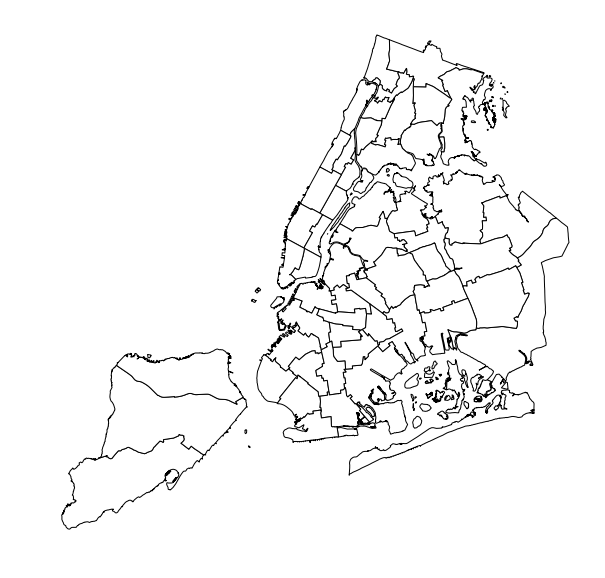

In [10]:
# using a choroplethNYC function that FBB wrote

import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=1);

## ASH -5 points for no title or caption for graph

### 2. American Fact Finder data on percentage of houses with broadband internet access

### 2.1 Get data with American Fact Finder (AFF) API:

In [11]:
# reading in my api key saved in censusAPI.py as myAPI = 'XXXXXXXXXXXXXXX'

from censusAPI import myAPI

In [12]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [13]:
affkeys = np.array(aff1y['variables'].keys())

In [14]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[(u'B28002_008E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_008M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_008MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_004M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_007MA',
  u'Annotation of Ma

In [15]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{u'attributes': u'B28002_001M,B28002_001EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [16]:
#keyword for the number of households with broarband access
keyNBB = "B28002_004E"
aff1y['variables'][keyNBB]

{u'attributes': u'B28002_004M,B28002_004EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [17]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [18]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [19]:
pumaPP.shape

(145, 5)

### 2.2 generate a feature for the percentage of households with broadband access

In [20]:
pumaBB['pcBB'] = (pumaBB['B28002_004E'] / pumaPP['B28002_001E']) * 100
del pumaBB["Unnamed: 4"]
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,78.150656


In [21]:
pumaBB.shape

(145, 5)

### 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_GCT2801.ST50&prodType=table

In [22]:
bbpc = pd.read_csv(PUIdata+"/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                  usecols=['GCT_STUB.target-geo-id2','HC01','HC02'])

In [23]:
bbpc.shape

(2431, 3)

In [24]:
header = bbpc.iloc[0]
bbpc = bbpc[1:]
bbpc.columns = header
bbpc.head()

,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [25]:
bbpc.columns = ['gid', 'percent', 'error']

In [26]:
bbpc.dtypes

gid        object
percent    object
error      object
dtype: object

In [27]:
bbpc['gid'] = bbpc['gid'].astype(int)
bbpc['percent'] = bbpc['percent'].astype(float)

In [28]:
bbpc['gid'] = bbpc['gid'] - 3600000
bbpc[::150]

,gid,percent,error
1,-3599999,74.7,0.5
151,-2997700,80.6,2.9
301,-2992885,85.9,3.9
451,-2698899,87.6,2.4
601,-2389496,69.6,3.3
751,-1896992,82.6,3.2
901,-1598696,85.7,2.0
1051,-1099000,86.6,2.5
1201,-799500,71.6,3.3
1351,-198898,90.8,2.1


In [29]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "percent"]]

In [30]:
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["percent"].astype(float))

In [31]:
diff_.shape

(145, 3)

In [32]:
diff_.describe()

,pcBB,percent,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


### 3 Plot a choropleth of NYC broadband access
### 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [33]:
pumashp.dtypes

puma           object
shape_leng    float64
shape_area    float64
geometry       object
dtype: object

In [34]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [35]:
pumaBB.dtypes

B28002_004E                    int64
NAME                          object
state                          int64
public use microdata area      int64
pcBB                         float64
dtype: object

In [36]:
pumashp = pumashp.merge(pumaBB, right_on="public use microdata area", 
                        left_on="puma")
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,69.425612


In [37]:
pumashp.shape

(55, 9)

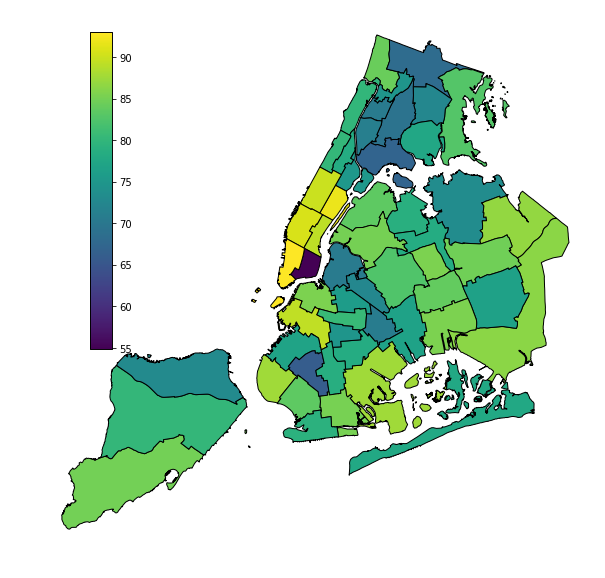

In [38]:
cp.choroplethNYC(pumashp, column='pcBB', color="white", edgecolor="black", lw=1);

##### Fig 1. This choropleth of New York shows the percent of households with broadband internet access by PUMA (a census geography). It can be seen there is a wide range of access levels. A few areas stand out: the Lower East Side appears to be the lowest percentage. Overall, the Bronx has a lower percent of households with broadband. Most neighborhoods in Manhattan, such as  Lower Manhattan and the Upper East Side have high levels of broadband.

### 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [39]:
linkurl = "https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv"
linkNYC = pd.read_csv(linkurl)
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [40]:
del linkNYC['Unnamed: 0']

In [41]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [42]:
linkNYC.shape

(1414, 4)

### combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab


In [43]:
#linkNYC['lonlat'] = "(" + linkNYC['longitude'].astype(str)+"," + " " + linkNYC['latitude'].astype(str) + ")"

In [44]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [45]:
linkNYC = gpd.GeoDataFrame(linkNYC)
linkNYC.crs = from_epsg(4326)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [46]:
# Taken from lab
# https://github.com/fedhere/PUI2017_fb55/blob/master/Lab9_cmp670/GeospatialAnalysis_CitiBike.ipynb 

# combine lat and lon to one column
linkNYC['lonlat']=zip(linkNYC.longitude,linkNYC.latitude)

# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


### plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

def choroplethNYC(df, column=None, cmap='viridis', ax=None,
                  cb=True, kind='continuous', alpha=1, color=None, edgecolor=None,
                  scheme=None, k=10, spacing=False, lw=1, width=None, side=False)

In [47]:
linkNYC['date_link_'] = pd.to_datetime(linkNYC['date_link_'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


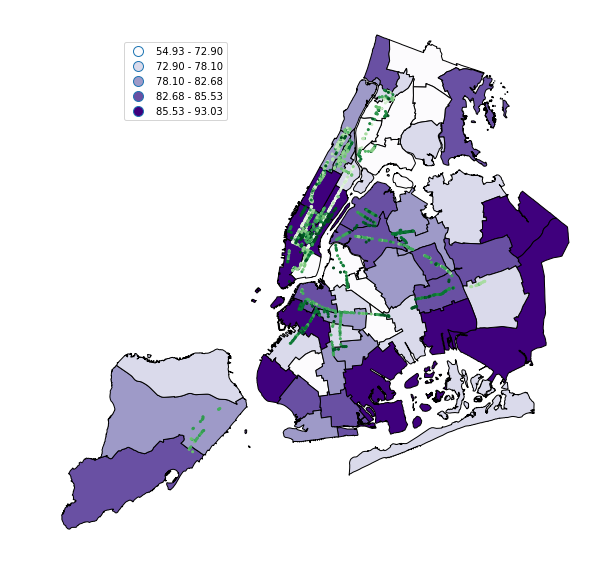

In [48]:
cp.choroplethNYC(pumashp, column='pcBB', cmap='Purples', color="white", 
                 edgecolor="black", lw=1, 
                 scheme='Quantiles', k=5);
scatter(linkNYC.longitude, linkNYC.latitude,4,linkNYC.date_link_, cmap="Greens")

##### Fig 2. This choropleth of NYC shows percentage of households with broadband internet access by PUMA, as well as the location of LinkNYC wifi towers throughout the city. There are many LinkNYC's in Manhattan, which overall has high internet access. There are fewer towers in the Bronx, which has some of the lowest rates of internet access. 

### 5 Find the number of linkNYC locations per person by PUMA
### 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [49]:
keyPop = 'B00001_001E'
aff1y['variables'][keyPop]

{u'attributes': u'B00001_001EA',
 u'concept': u'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 u'group': u'B00001',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [50]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
del pumaPop['Unnamed: 4']
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area
0,3075,"St. Lawrence County PUMA, New York",36,100
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,2736,"Warren & Washington Counties PUMA, New York",36,300
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [51]:
pumaPop.shape

(145, 4)

In [52]:
pumaPop = pumaPop[['B00001_001E', 'public use microdata area']]
pumaPop.head()

,B00001_001E,public use microdata area
0,3075,100
1,4356,200
2,2736,300
3,2722,401
4,2874,402


In [53]:
pumashpPop = pumashp.merge(pumaPop, right_on='public use microdata area', left_on='puma')
pumashpPop.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area_x,pcBB,B00001_001E,public use microdata area_y
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,84.275820,1517,3701
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,68.310015,1959,3702
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,82.826141,1305,3703
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,72.553737,1882,3704
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,69.425612,2011,3705


In [54]:
pumashpPop.shape

(55, 11)

### 5.2 find the number of station per 100 people per PUMA


In [55]:
linkNYC2 = gpd.GeoDataFrame(linkNYC)
linkNYC2.crs = from_epsg(2263)

pumashp2 = gpd.GeoDataFrame(pumashp)
pumashp2.crs = from_epsg(2263)

linkNYC2.shape, pumashp2.shape

((1414, 6), (55, 9))

In [56]:
linkpp = gpd.sjoin(pumashp2,linkNYC2, how="left").groupby("puma").count().reset_index()
linkpp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,pcBB,index_right,link_site,longitude,date_link_,latitude,lonlat
0,3701,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,3702,1,1,1,1,1,1,1,1,0,0,0,0,0,0
2,3703,1,1,1,1,1,1,1,1,0,0,0,0,0,0
3,3704,1,1,1,1,1,1,1,1,0,0,0,0,0,0
4,3705,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [57]:
linkpp = linkpp[['puma','link_site']]
linkpp[::4]

,puma,link_site
0,3701,1
4,3705,1
8,3709,0
12,3803,61
16,3807,230
20,3901,4
24,4002,1
28,4006,33
32,4010,10
36,4014,0


In [58]:
linkpp.shape

(55, 2)

### at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

In [59]:
pumashpPop.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area_x,pcBB,B00001_001E,public use microdata area_y
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,84.275820,1517,3701
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,68.310015,1959,3702
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,82.826141,1305,3703
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,72.553737,1882,3704
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,69.425612,2011,3705


In [60]:
linkNYCp100p = linkpp.merge(pumashpPop, right_on='puma',
                            left_on='puma', how='outer')
linkNYCp100p.head()

,puma,link_site,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area_x,pcBB,B00001_001E,public use microdata area_y
0,3701,1,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,84.275820,1517,3701
1,3702,0,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,68.310015,1959,3702
2,3703,0,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,82.826141,1305,3703
3,3704,0,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,72.553737,1882,3704
4,3705,1,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,69.425612,2011,3705


In [61]:
linkNYCp100p.shape

(55, 12)

In [62]:
linkNYCp100p["LinkNYC_per100"] = (linkNYCp100p['link_site'] / linkNYCp100p['B00001_001E']) * 100
linkNYCp100p = linkNYCp100p[['puma', 'link_site', 'geometry', 'LinkNYC_per100']]
linkNYCp100p.head(10)

,puma,link_site,geometry,LinkNYC_per100
0,3701,1,POLYGON ((-73.89641133483133 40.90450452082026...,0.065920
1,3702,0,POLYGON ((-73.86477258283533 40.90201244187379...,0.000000
2,3703,0,(POLYGON ((-73.78833349834532 40.8346671297593...,0.000000
3,3704,0,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.000000
4,3705,1,POLYGON ((-73.87045508990893 40.86663286876232...,0.049727
5,3706,20,POLYGON ((-73.91328437051338 40.85961860183316...,1.569859
6,3707,29,POLYGON ((-73.91328437051338 40.85961860183316...,1.873385
7,3708,19,"POLYGON ((-73.92478318783078 40.8447526648105,...",1.299590
8,3709,0,(POLYGON ((-73.83667856364177 40.8175887629137...,0.000000
9,3710,19,(POLYGON ((-73.89680883223774 40.7958084451597...,0.948104


In [63]:
linkNYCp100p['LinkNYC_per100'].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: LinkNYC_per100, dtype: float64

In [64]:
linkNYCp100p.dtypes

puma                int64
link_site           int64
geometry           object
LinkNYC_per100    float64
dtype: object

In [65]:
linkNYCp100p = gpd.GeoDataFrame(linkNYCp100p)

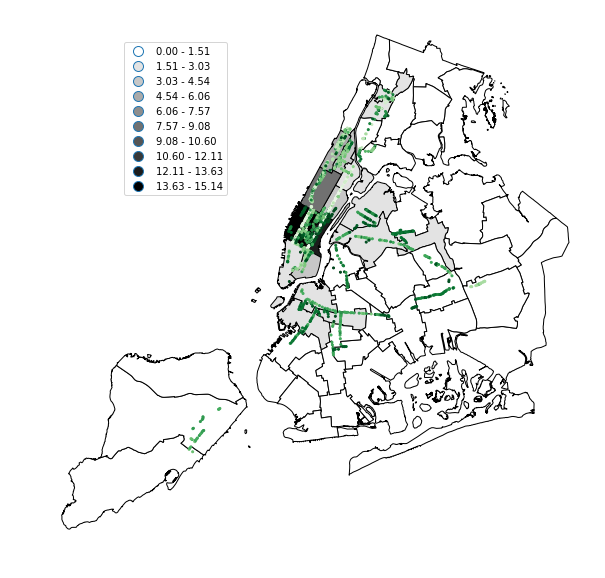

In [66]:
cp.choroplethNYC(linkNYCp100p, column='LinkNYC_per100', cmap='gist_gray_r', 
                 color="white", edgecolor="black", lw=1, 
                 scheme='Equal_interval', k=10);
scatter(linkNYC.longitude, linkNYC.latitude,4,linkNYC.date_link_, cmap="Greens")

##### Fig 3. Mapping a choropleth of LinkNYC units per 100 residents shows that Manhattan has a high density of units compared to other boroughs. In particular, midtown and the Upper West Side are notably high. 

### Extra credit 1:
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

(array([ 27.,   5.,   6.,   8.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  0.        ,   0.50471802,   1.00943603,   1.51415405,
          2.01887206,   2.52359008,   3.0283081 ,   3.53302611,
          4.03774413,   4.54246215,   5.04718016,   5.55189818,
          6.05661619,   6.56133421,   7.06605223,   7.57077024,
          8.07548826,   8.58020628,   9.08492429,   9.58964231,
         10.09436032,  10.59907834,  11.10379636,  11.60851437,
         12.11323239,  12.61795041,  13.12266842,  13.62738644,
         14.13210445,  14.63682247,  15.14154049]),
 <a list of 30 Patch objects>)

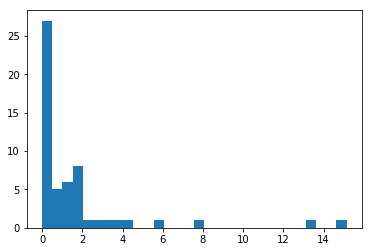

In [67]:
pl.hist(linkNYCp100p['LinkNYC_per100'], bins=30)

In [68]:
linkNYCp100p['log_LinkNYC_per100'] = linkNYCp100p['LinkNYC_per100'] * 100
linkNYCp100p['log_LinkNYC_per100'] = np.log(linkNYCp100p['log_LinkNYC_per100'])
linkNYCp100p.head()

,puma,link_site,geometry,LinkNYC_per100,log_LinkNYC_per100
0,3701,1,POLYGON ((-73.89641133483133 40.90450452082026...,0.065920,1.885850
1,3702,0,POLYGON ((-73.86477258283533 40.90201244187379...,0.000000,-inf
2,3703,0,(POLYGON ((-73.78833349834532 40.8346671297593...,0.000000,-inf
3,3704,0,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.000000,-inf
4,3705,1,POLYGON ((-73.87045508990893 40.86663286876232...,0.049727,1.603953


In [69]:
linkNYCp100p = linkNYCp100p.replace([np.inf, -np.inf], 0)

In [70]:
linkNYCp100p['log_LinkNYC_per100'].min(), linkNYCp100p['log_LinkNYC_per100'].max() 

(0.0, 7.3226121783036051)

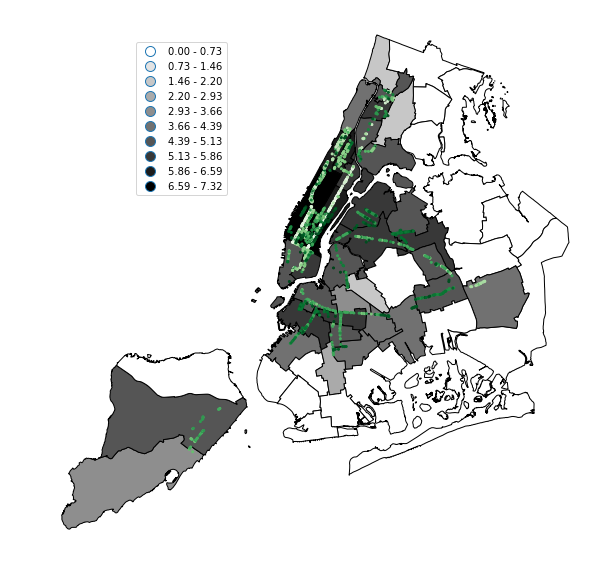

In [71]:
cp.choroplethNYC(linkNYCp100p, column='log_LinkNYC_per100', cmap='gist_gray_r', 
                 color="white", edgecolor="black", lw=1, 
                 scheme='Equal_interval', k=10);
scatter(linkNYC.longitude, linkNYC.latitude,4,linkNYC.date_link_, cmap="Greens")

###### Fig 4. This choropleth maps the number of LinkNYC units per 100 residents by taking the log of the value. This shrinks the data to a smaller scale, making it easier to identify patterns or anomalies. For instance, we can now see that Staten Island has three distinct ratios, while in Fig 3, the trend across Staten Island appeared to be uniform.

### Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC

## ASH Score 95. Extra Credit 50